<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/feature-engineering-bookcamp/01_diagnosing_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [ ]:
!pip install feature-engine

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import time
np.random.seed(0)
import random
random.seed(0)

In [3]:
from sklearn.impute import SimpleImputer
from feature_engine.imputation import EndTailImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer  # class to help make dummy variables
from functools import reduce

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split

from scipy.stats import zscore

In [ ]:
!wget https://github.com/rahiakela/data-science-research-and-practice/raw/main/feature-engineering-bookcamp/data/covid_flu.csv

In [5]:
def simple_grid_search(x_train, y_train, x_test, y_test, feature_engineering_pipeline):
    '''
    simple helper function to grid search an ExtraTreesClassifier model and
    print out a classification report for the best param set.
    Best here is defined as having the best cross-validated accuracy on the training set
    '''

    params = {  # some simple parameters to grid search
        'max_depth': [10, None],
        'n_estimators': [10, 50, 100, 500],
        'criterion': ['gini', 'entropy']
    }

    base_model = ExtraTreesClassifier()

    model_grid_search = GridSearchCV(base_model, param_grid=params, cv=3)
    start_time = time.time()  # capture the start time
    if feature_engineering_pipeline:  # fit FE pipeline to training data and use it to transform test data
        parsed_x_train = feature_engineering_pipeline.fit_transform(x_train, y_train)
        parsed_x_test = feature_engineering_pipeline.transform(x_test)
    else:
        parsed_x_train = x_train
        parsed_x_test = x_test

    parse_time = time.time()
    print(f"Parsing took {(parse_time - start_time):.2f} seconds")

    model_grid_search.fit(parsed_x_train, y_train)
    fit_time = time.time()
    print(f"Training took {(fit_time - start_time):.2f} seconds")

    best_model = model_grid_search.best_estimator_

    print(classification_report(y_true=y_test, y_pred=best_model.predict(parsed_x_test)))
    end_time = time.time()
    print(f"Overall took {(end_time - start_time):.2f} seconds")

    return best_model

##EDA

In [6]:
covid_flu = pd.read_csv("covid_flu.csv")
covid_flu.head()

,Diagnosis,InitialPCRDiagnosis,Age,Sex,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue
0,H1N1,NaN,67.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN,No,NaN,38.111111,No
1,H1N1,NaN,29.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H1N1,NaN,22.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H1N1,NaN,20.0,F,NaN,NaN,NaN,NaN,NaN,NaN,immuno,NaN,NaN,Yes,Yes,NaN,No,NaN,36.555556,Yes
4,H1N1,NaN,21.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
covid_flu.shape

(1482, 20)

In [8]:
# Let’s see what percent of values are missing for each feature
covid_flu.isnull().mean()

Diagnosis                      0.000000
InitialPCRDiagnosis            0.929825
Age                            0.018893
Sex                            0.051282
neutrophil                     0.930499
serumLevelsOfWhiteBloodCell    0.898111
lymphocytes                    0.894737
CReactiveProteinLevels         0.907557
DurationOfIllness              0.941296
CTscanResults                  0.892713
RiskFactors                    0.858974
GroundGlassOpacity             0.937247
Diarrhea                       0.696356
Fever                          0.377193
Coughing                       0.420378
ShortnessOfBreath              0.949393
SoreThroat                     0.547908
NauseaVomitting                0.715924
Temperature                    0.576248
Fatigue                        0.641700
dtype: float64

In [9]:
# let's see percent breakdown of response variable
covid_flu["Diagnosis"].value_counts(normalize=True)

H1N1       0.723347
COVID19    0.276653
Name: Diagnosis, dtype: float64

In [10]:
covid_flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Diagnosis                    1482 non-null   object 
 1   InitialPCRDiagnosis          104 non-null    object 
 2   Age                          1454 non-null   float64
 3   Sex                          1406 non-null   object 
 4   neutrophil                   103 non-null    float64
 5   serumLevelsOfWhiteBloodCell  151 non-null    float64
 6   lymphocytes                  156 non-null    float64
 7   CReactiveProteinLevels       137 non-null    object 
 8   DurationOfIllness            87 non-null     float64
 9   CTscanResults                159 non-null    object 
 10  RiskFactors                  209 non-null    object 
 11  GroundGlassOpacity           93 non-null     object 
 12  Diarrhea                     450 non-null    object 
 13  Fever             

##Feature improvement

**Imputing missing quantitative data**

In [11]:
# Let’s grab the numerical columns and put them in a list
numeric_types = ["float16", "float32", "float64", "int16", "int32", "int64"]
numerical_columns = covid_flu.select_dtypes(include=numeric_types).columns.tolist()
numerical_columns

['Age',
 'neutrophil',
 'serumLevelsOfWhiteBloodCell',
 'lymphocytes',
 'DurationOfIllness',
 'Temperature']

In [12]:
## MEAN/MEDIAN IMPUTATION
num_imputer = SimpleImputer(strategy="mean")  # Could be mean or median for numerical values
print(covid_flu["lymphocytes"].head())        # Shows the first five values before imputing
print(f"\n\nMean of Lymphocytes column is {covid_flu['lymphocytes'].mean()}\n\n")
print(num_imputer.fit_transform(covid_flu[["lymphocytes"]])[:5])

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: lymphocytes, dtype: float64


Mean of Lymphocytes column is 1.8501538461538463


[[1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]
 [1.85015385]]


<Axes: title={'center': 'Lymphocytes'}, ylabel='Frequency'>

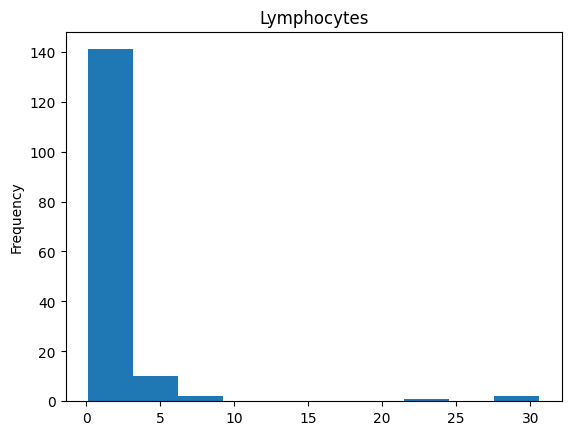

In [13]:
# End-of-tail imputation
covid_flu["lymphocytes"].plot(title="Lymphocytes", kind="hist", xlabel="cells/μL")

<Axes: title={'center': 'Lymphocytes(Imputed)'}, ylabel='Frequency'>

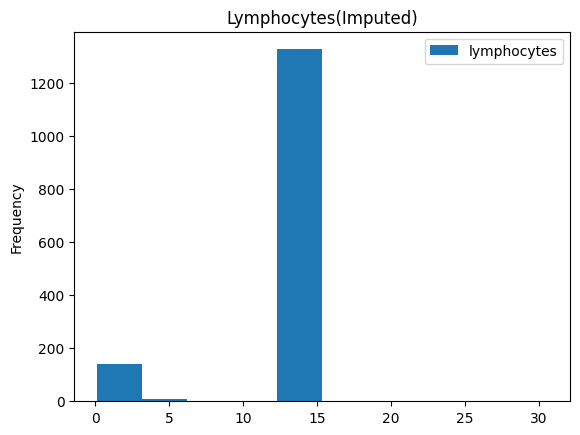

In [14]:
# let's impute values into the feature, using the default Gaussian method (arithmetic mean + 3 * standard deviation)
EndTailImputer().fit_transform(covid_flu[["lymphocytes"]]).plot(title="Lymphocytes(Imputed)", kind="hist", xlabel="cells/μL")

In [15]:
# Gaussian method (arithmetic mean + 3 * standard deviation)
# arithmetic mean of the feature is 1.850154, and our standard deviation is 3.956668
# 1.850154 + 3 * 3.956668 = 13.720158
1.850154 + 3 * 3.956668

13.720158

In [16]:
# If our arithmetic mean was 8.34 and our standard deviation was 2.35
8.34 + 3 * 2.35

15.39

**Imputing missing qualitative data**

In [17]:
# Counting values of qualitative features
categorical_types = ["O"]  # The "object" type in pandas
categorical_columns = covid_flu.select_dtypes(include=categorical_types).columns.tolist()
categorical_columns.remove("Diagnosis") # remove response variable from this list
for categorical_column in categorical_columns:
  print("=========================")
  print(categorical_column)
  print("=========================")
  print(covid_flu[categorical_column].value_counts(dropna=False))

InitialPCRDiagnosis
NaN    1378
Yes     100
No        4
Name: InitialPCRDiagnosis, dtype: int64
Sex
M      748
F      658
NaN     76
Name: Sex, dtype: int64
CReactiveProteinLevels
NaN           1345
8                3
0.5              3
15               3
111              2
              ... 
5.78             1
67.62            1
13.2 mg/dL       1
21.27            1
0.6              1
Name: CReactiveProteinLevels, Length: 121, dtype: int64
CTscanResults
NaN    1323
Yes     144
No       15
Name: CTscanResults, dtype: int64
RiskFactors
NaN                                                                   1273
asthma                                                                  36
pneumonia                                                               21
immuno                                                                  21
diabetes                                                                16
                                                                      ... 
diabetes,

In [18]:
# Let’s start by turning the Sex column into a true/false binary column
covid_flu["Female"] = covid_flu["Sex"] == "F"
del covid_flu["Sex"]

# replace Yes and No with true and false
covid_flu = covid_flu.replace({"Yes": True, "No": False})

In [19]:
covid_flu["Female"].head()

0     True
1    False
2     True
3     True
4    False
Name: Female, dtype: bool

In [20]:
# MOST-FREQUENT CATEGORY IMPUTATION
cat_imputer = SimpleImputer(strategy="most_frequent")

In [21]:
# Transforming turns the column into a NumPy array
print(covid_flu["Coughing"].head())
cat_imputer.fit_transform(covid_flu[["Coughing"]])[:5]

0    True
1     NaN
2     NaN
3    True
4     NaN
Name: Coughing, dtype: object


array([[True],
       [True],
       [True],
       [True],
       [True]], dtype=object)

##Feature construction

**Numerical feature transformations**

<Axes: title={'center': 'Lymphocytes'}, ylabel='Frequency'>

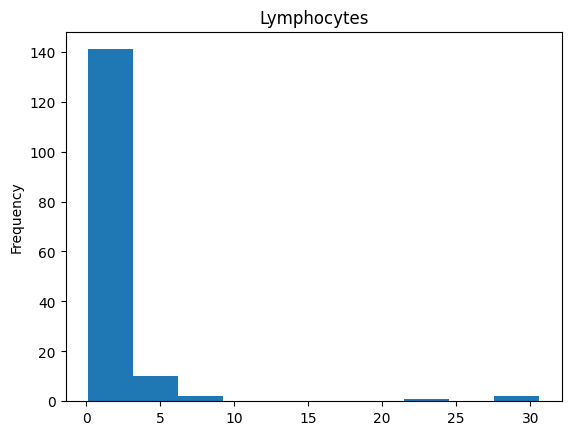

In [22]:
# LOG TRANSFORMS
covid_flu["lymphocytes"].plot(title="Lymphocytes",kind="hist", xlabel="cells/μL")  # Before log transform

<Axes: title={'center': 'Lymphocytes(Log Transformed)'}, ylabel='Frequency'>

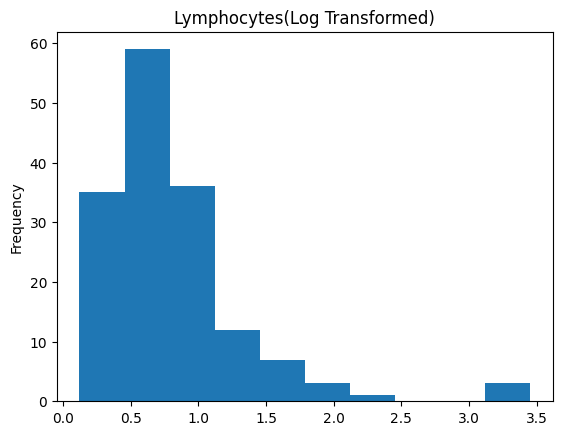

In [23]:
covid_flu["lymphocytes"].map(np.log1p).plot(title="Lymphocytes(Log Transformed)",kind="hist", xlabel="cells/μL")  # Log transform of lymphocytes

In [24]:
# BOX-COX TRANSFORMS

# It looks like Age may have some zeros in it, which won’t work with Box-Cox.
covid_flu[covid_flu["Age"] == 0].head(3)

,Diagnosis,InitialPCRDiagnosis,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,CReactiveProteinLevels,DurationOfIllness,CTscanResults,RiskFactors,GroundGlassOpacity,Diarrhea,Fever,Coughing,ShortnessOfBreath,SoreThroat,NauseaVomitting,Temperature,Fatigue,Female
726,H1N1,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,"asthma, respiratory disease",NaN,True,True,True,NaN,True,False,NaN,NaN,False
727,H1N1,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,True,NaN,False,False,NaN,NaN,True
728,H1N1,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,NaN,True,False,NaN,NaN,True


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

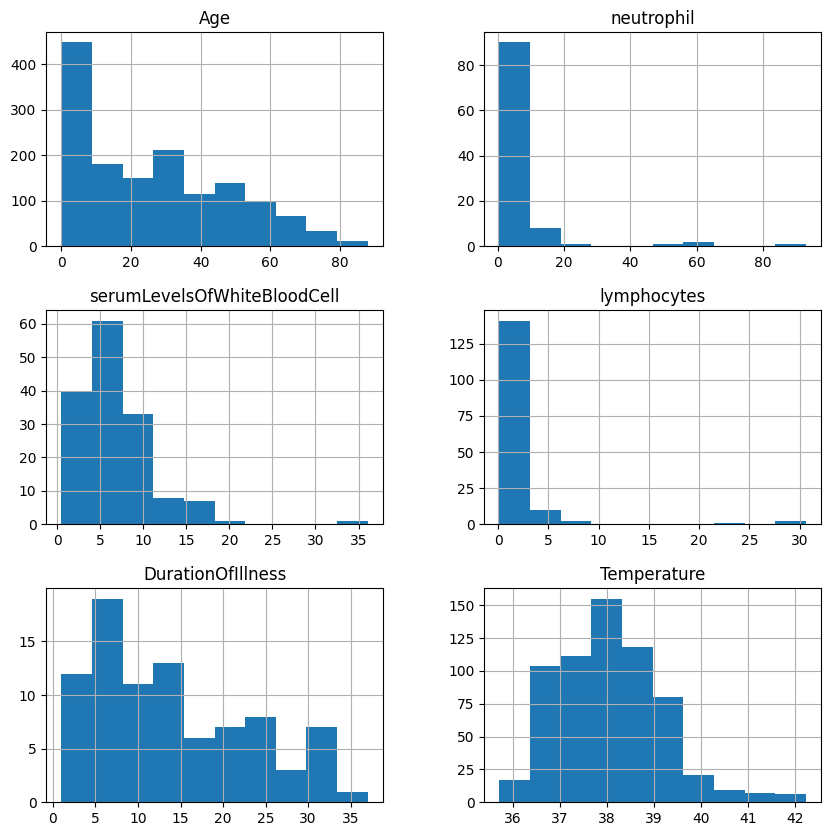

In [25]:
# To make Age strictly positive
covid_flu["Age"] = covid_flu["Age"] + 0.01

# quantitative features before applying the Box-Cox transformation
pd.DataFrame(covid_flu[numerical_columns]).hist(figsize=(10, 10))

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

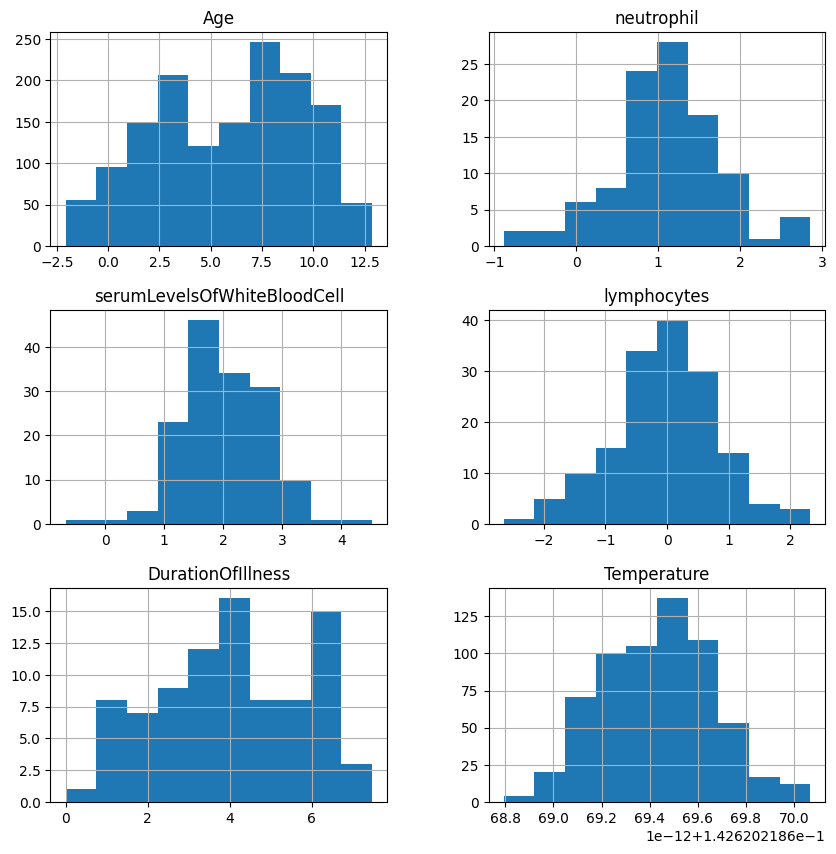

In [26]:
# Now, we can apply our transformation
boxcox_transformer = PowerTransformer(method="box-cox", standardize=False)
pd.DataFrame(boxcox_transformer.fit_transform(covid_flu[numerical_columns]), columns=numerical_columns).hist(figsize=(10, 10))

In [27]:
# A lambda value of 1 would not change the shape of our distribution,
# so if we see a value very close to 1, our data were already close to normally distributed
boxcox_transformer.lambdas_

array([ 0.41035252, -0.22261792,  0.12473207, -0.24415703,  0.36376995,
       -7.01162857])

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'neutrophil'}>],
       [<Axes: title={'center': 'serumLevelsOfWhiteBloodCell'}>,
        <Axes: title={'center': 'lymphocytes'}>],
       [<Axes: title={'center': 'DurationOfIllness'}>,
        <Axes: title={'center': 'Temperature'}>]], dtype=object)

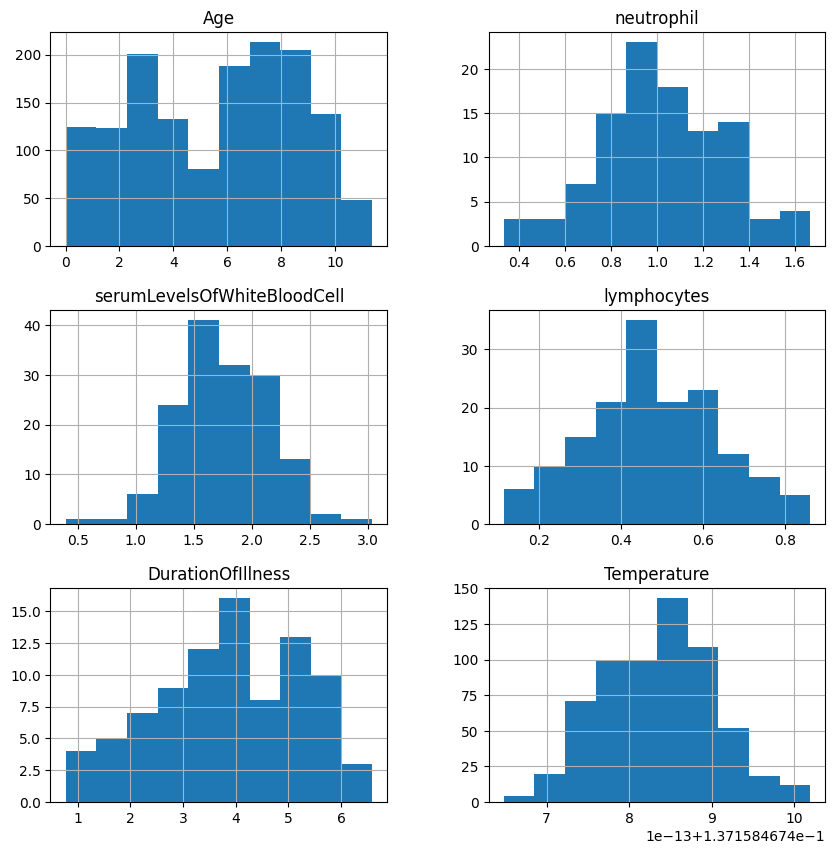

In [28]:
# Yeo-Johnson transformation
yeo_johnson_transformer = PowerTransformer(method="yeo-johnson", standardize=False)
pd.DataFrame(yeo_johnson_transformer.fit_transform(covid_flu[numerical_columns]), columns=numerical_columns).hist(figsize=(10, 10))

In [29]:
# FEATURE SCALING
covid_flu[numerical_columns].describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1454.000000,103.000000,151.000000,156.000000,87.000000,628.000000
mean,26.481040,6.854078,6.885159,1.850154,13.988506,38.068312
std,21.487982,12.690131,4.346668,3.956668,9.043171,1.094468
min,0.010000,0.446000,0.500000,0.130000,1.000000,35.722222
25%,7.010000,2.160000,3.995000,0.637500,7.000000,37.222222
50%,24.010000,3.310000,5.690000,0.905500,12.000000,38.000000
75%,42.010000,6.645000,9.155000,1.605000,20.000000,38.722222
max,88.010000,93.000000,36.070000,30.600000,37.000000,42.222222


In [30]:
# Let’s start by applying the StandardScalar to standardize our data
# mean of 0 and std of 1 but ranges are different (see min and max)
pd.DataFrame(StandardScaler().fit_transform(covid_flu[numerical_columns]), columns=numerical_columns).describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1.454000e+03,103.000000,1.510000e+02,1.560000e+02,8.700000e+01,6.280000e+02
mean,1.368308e-16,0.000000,-1.411674e-16,-1.708035e-17,-5.614921e-17,1.708471e-15
std,1.000344e+00,1.004890,1.003328e+00,1.003221e+00,1.005797e+00,1.000797e+00
min,-1.232324e+00,-0.507435,-1.473866e+00,-4.361482e-01,-1.444604e+00,-2.145299e+00
25%,-9.064480e-01,-0.371709,-6.671264e-01,-3.074706e-01,-7.772737e-01,-7.736770e-01
50%,-1.150359e-01,-0.280644,-2.758748e-01,-2.395187e-01,-2.211651e-01,-6.246559e-02
75%,7.229298e-01,-0.016556,5.239403e-01,-6.215921e-02,6.686088e-01,5.979450e-01
max,2.864398e+00,6.821614,6.736646e+00,7.289577e+00,2.559378e+00,3.798396e+00


In [31]:
# Let’s see this now for min-max standardization
# mean and std are different but min and max are 0s and 1s
pd.DataFrame(MinMaxScaler().fit_transform(covid_flu[numerical_columns]), columns=numerical_columns).describe()

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,DurationOfIllness,Temperature
count,1454.000000,103.000000,151.000000,156.000000,87.000000,628.000000
mean,0.300807,0.069236,0.179510,0.056454,0.360792,0.360937
std,0.244182,0.137111,0.122200,0.129855,0.251199,0.168380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.079545,0.018519,0.098257,0.016656,0.166667,0.230769
50%,0.272727,0.030944,0.145909,0.025451,0.305556,0.350427
75%,0.477273,0.066977,0.243323,0.048408,0.527778,0.461538
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Constructing categorical data**

<Axes: title={'center': 'Age (Uniform Binning)'}, ylabel='Frequency'>

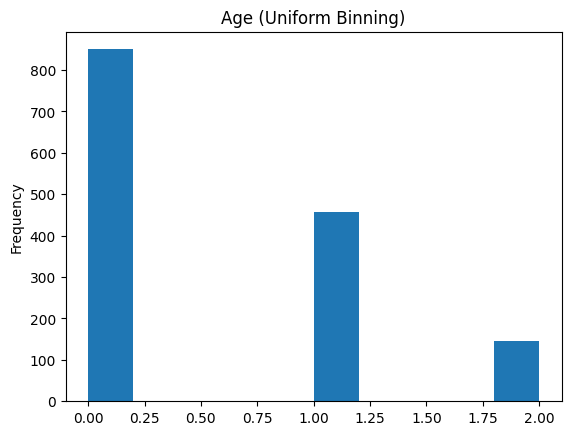

In [32]:
############# BINNING ######################

# Uniform bins are of equal width
binner = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform")
binned_data = binner.fit_transform(covid_flu[["Age"]].dropna())

# uniform strategy will create bins of equal width
pd.Series(binned_data.reshape(-1, )).plot(title="Age (Uniform Binning)", kind="hist", xlabel="Age")

<Axes: title={'center': 'Age (Quantile Binning)'}, ylabel='Frequency'>

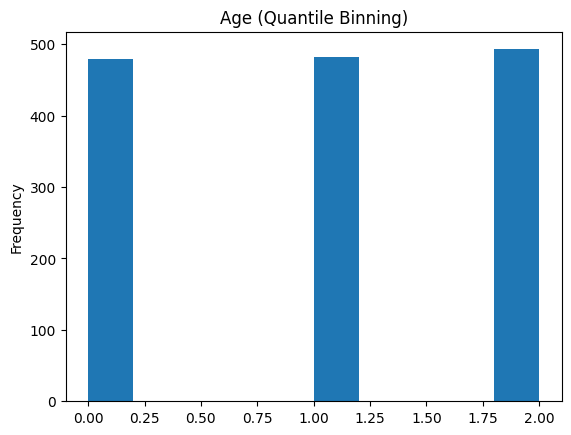

In [33]:
# Quantile bins are of equal height
binner = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="quantile")
binned_data = binner.fit_transform(covid_flu[["Age"]].dropna())

# Quantile will create bins of roughly equal height
pd.Series(binned_data.reshape(-1, )).plot(title="Age (Quantile Binning)", kind="hist", xlabel="Age")

<Axes: title={'center': 'Age (KMeans Binning)'}, ylabel='Frequency'>

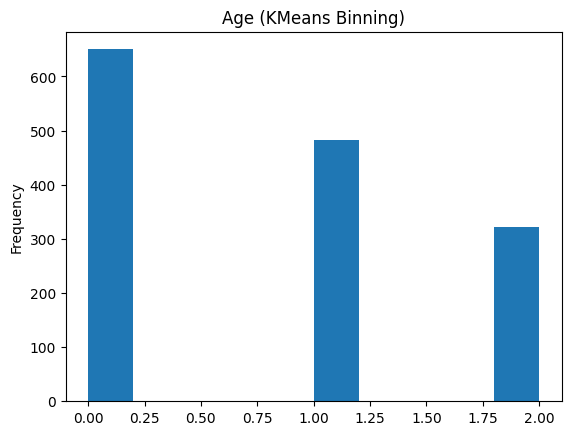

In [34]:
# K-means bins are chosen by assigning them to the nearest cluster on a onedimensional k-means algorithm outcome
binner = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="kmeans")
binned_data = binner.fit_transform(covid_flu[["Age"]].dropna())

# KMeans will run a k-means cluster on each feature independently
pd.Series(binned_data.reshape(-1, )).plot(title="Age (KMeans Binning)", kind="hist", xlabel="Age")

In [35]:
############## ONE-HOT ENCODINGS ############

# A custom data transformer to deal with our messy RiskFactors column
class DummifyRiskFactor(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.label_binarizer = None

  def parse_risk_factors(self, comma_sep_factors):
    """asthma,heart disease -> ['asthma', 'heart disease']"""
    try:
      return [s.strip().lower() for s in comma_sep_factors.split(",")]
    except:
      return []

  def fit(self, X, y=None):
    # Class to help make dummy variables
    self.label_binarizer = MultiLabelBinarizer()
    # Creates a dummy variable for each risk factor
    self.label_binarizer.fit(X.apply(self.parse_risk_factors))
    return self

  def transform(self, X, y=None):
    return self.label_binarizer.transform(X.apply(self.parse_risk_factors))

In [36]:
# Let’s use our transformer just like any other scikit-learn transformer
drf = DummifyRiskFactor()
risks = drf.fit_transform(covid_flu["RiskFactors"])
print(risks.shape)
pd.DataFrame(risks, columns=drf.label_binarizer.classes_)

(1482, 41)


,asthma,athero,atopic dermatitis and repetitive respiratory infections,begin tumor (removed),chronic,chronic endrocrine disorder,chronic liver dieseas,chronic liver disorder,chronic neurological disorders,chronic obstructive pulmonary disease,...,lung disease,myxoma of abdominal cavity,obesity,pneumomediastinum and subcutaneous emphysema,pneumonia,pre-eclampsia,prom,renal disease,respiratory disease,rheumatoid arthritis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
####### DOMAIN-SPECIFIC FEATURE CONSTRUCTION ######

# Construct a new categorical column that is an amalgamation of several flu symptoms
covid_flu["FluSymptoms"] = covid_flu[["Diarrhea", "Fever", "Coughing", "SoreThroat", "NauseaVomitting", "Fatigue"]].sum(axis=1) >= 2
print(covid_flu["FluSymptoms"].value_counts())

False    753
True     729
Name: FluSymptoms, dtype: int64


In [38]:
# No missing values
print(covid_flu["FluSymptoms"].isnull().sum())

0


In [ ]:
# Aggregate all binary columns in a list
binary_features = [
    "Female", "GroundGlassOpacity", "CTscanResults",
    "Diarrhea", "Fever", "FluSymptoms", "Coughing",
    "SoreThroat", "NauseaVomitting", "Fatigue", "InitialPCRDiagnosis"
]

##Feature engineering pipeline